**ADF(Augmented Dickey-Fuller) Test for Pairs Trading**

In [29]:
from statsmodels.tsa.stattools import coint
from itertools import combinations,product
import pandas as pd
import yfinance
import os
import numpy as np
import multiprocessing as mp
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import decimal
import copy
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from statsmodels.tsa.stattools import adfuller
from itertools import product
from sklearn.linear_model import LinearRegression
from time import sleep

The study aims to apply Augmented Dickey-Fuller test for pairs trading to shortlist stationary or stationary pairs with constant trend.

A list of pairs will not be provided as one can try this with any subset of pairs traded in any market but since `yfinance` will be used to extract the data, it will be easier for the user to pick the stocks having daily data on `yfinance`. `statsmodels.tsa`'s `adfuller` method will be used to apply the test. The test will be applied on the ratio of the pair's daily spot price for the last 3 years. The data should be provided in csv format in a single column for the code to work uninterrupted.

Let's prepare the data and join them altogether.

In [67]:
stock_tickers = [x for x in pd.read_excel('stock_list.xlsx').loc[:,"stock"].values.tolist()]
el_tickers = []
av_tickers = []
for ticker in stock_tickers:
  try:
    ticker_info = yfinance.Ticker(ticker)
    stock_data = ticker_info.history(period="min")
    av_tickers.append(ticker)
  except:
    el_tickers.append(ticker)

In [5]:
def merge_derivative(data,ticker,period,scale):
  ticker_info = yfinance.Ticker(ticker)
  sdata = ticker_info.history(period=period)
  if sdata.shape[0] != 0:
    sdata.index = sdata.index.date
    sdata.index.names = ["date"]
    if data.index[0]==sdata.index[0]:
      if scale:
        sdata[ticker] = ((sdata['Open'] + sdata['Close'])/2)/data['USDTRY=X']
      else:
        sdata[ticker] = ((sdata['Open'] + sdata['Close'])/2)
      sdata = sdata.loc[:,[ticker]]
      data = data.join(sdata,rsuffix="Date",lsuffix="date",how="left")
  return data

In [68]:
lastny = "3y"
ticker_info = yfinance.Ticker("XU100.IS")
date_data = ticker_info.history(period=lastny)
date_data['XU100.IS'] = (date_data['Open'] + date_data['Close'])/2
date_data = date_data.loc[:,['XU100.IS']]
date_data['XU100.IS'] = np.where(date_data.index >= '2020-07-25',date_data['XU100.IS']*100,date_data['XU100.IS'])
merged_data = pd.DataFrame({'XU100.IS':date_data['XU100.IS']})
merged_data.index = merged_data.index.date
merged_data.index.names = ["Date"]
merged_data = merge_derivative(merged_data,"USDTRY=X",lastny,False)
merged_data = merged_data[~(np.sum(merged_data.isnull(),axis=1) > 0)]

for ticker in av_tickers:
  merged_data = merge_derivative(merged_data,ticker,lastny,False)

nan_stocks = np.sum(merged_data.isnull(),axis=0).index[np.sum(merged_data.isnull(),axis=0) > 20].tolist()
if len(nan_stocks) != 0:
  merged_data = merged_data.drop(nan_stocks,axis=1)

nan_rows = np.sum(merged_data.isnull(),axis=1).index[np.sum(merged_data.isnull(),axis=1) > 0].tolist()
if len(nan_rows) != 0:
  merged_data = merged_data.drop(nan_rows,axis=0)
merged_data.head()

In this section, the rationale behind using the ADF test for picking up stationary pairs will be provided.
$$
\Delta y_t = c + s_t + \gamma y_{t-1} + \sum_i \beta_i\Delta y_i + \epsilon_t
$$
where $\Delta$ denotes the value difference between consecutive points in time, c is the constant term, $s_t$ is the linear trend component to be estimated, $\beta_i$ is the regression coefficients to correct dependency of current change to past changes as $i \in ({t-k},\ldots,t-1)$ and $\gamma$ denotes the test statistic which will be collected to test stationarity. A more strict criterion (BIC) was used to choose $k$ but a list strict one might be passed as AIC based on one's will. \\
$$
\\
$$
The test is as the following
$$
H_0: \gamma = 0 \\
H_A: \gamma < 0 \\
$$
For simplicty, assuming $\gamma=0$ and any other parameters are $0$ and $\epsilon$ is normal, the equation will boil down to a normal random walk as the following
$$
\Delta y_t = \epsilon_t
$$
so the changes at time $t$ will be independent of the values at $t-1$ meaning the changes will be white noise and the process will not be stationary.

Text(0.5, 1.0, 'Standard Normal Random Walk with 100000 Iterations')

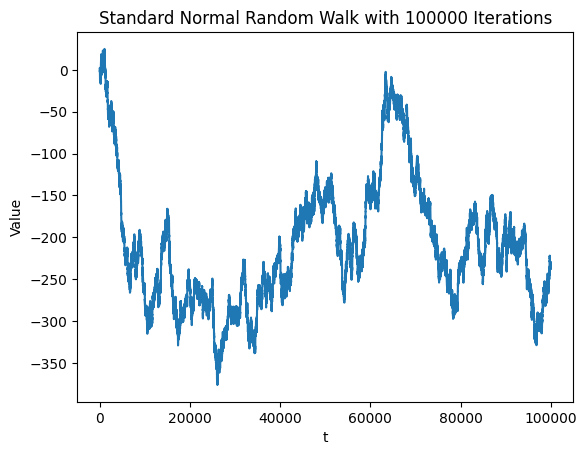

In [7]:
np.random.seed(3)
nr_walk = np.cumsum(np.random.normal(0,1,100000))
plt.plot(range(len(nr_walk)),nr_walk)
plt.xlabel("t")
plt.ylabel("Value")
plt.title("Standard Normal Random Walk with 100000 Iterations")

As it is seen above, the Markov process is not stationary as it is quite sticky. Let's see if the pictures changes when $\gamma$ is slightly below $0$. Ideally, when this condition is satisfied, every positive value will be followed by a negative $\Delta$ which will fade out the increase which will ideally yield to stationarity. Let's set the value to the $-0.05$

Text(0.5, 1.0, 'Standard Normal Random Walk with 5000 Iterations')

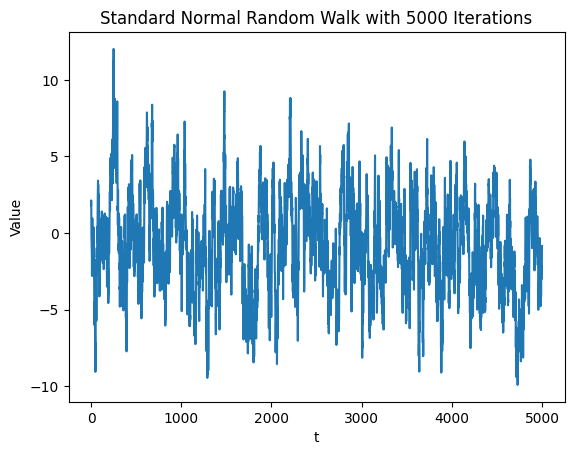

In [15]:
np.random.seed(3)
gamma = 0.95
epsilon = np.random.normal(0,1,5000)
y_prev = 0
y_list = list()
for i in epsilon:
  y_prev = gamma*y_prev + i
  y_list.append(y_prev)

plt.plot(range(len(y_list)),y_list)
plt.xlabel("t")
plt.ylabel("Value")
plt.title("Standard Normal Random Walk with 5000 Iterations")

The values seem stationary even with a slightly lower value of $\gamma$. Similarly, a trending process might be shown to be nonstationary as $\gamma=0$ and vice versa. Let's apply adf test per pair's ratio

In [69]:
adfuller_res = {}
combinations = list(product(merged_data.columns,merged_data.columns))
combinations = [(x,y) for x,y in combinations if x!=y]
tp = 0.001
for x,y in combinations:
  adfuller_res = adfuller(merged_data[x]/merged_data[y],regression="ctt",autolag="BIC")[1]
  if adfuller_res < tp:
    print(x+"-"+y)

Text(0, 0.5, 'Ratio')

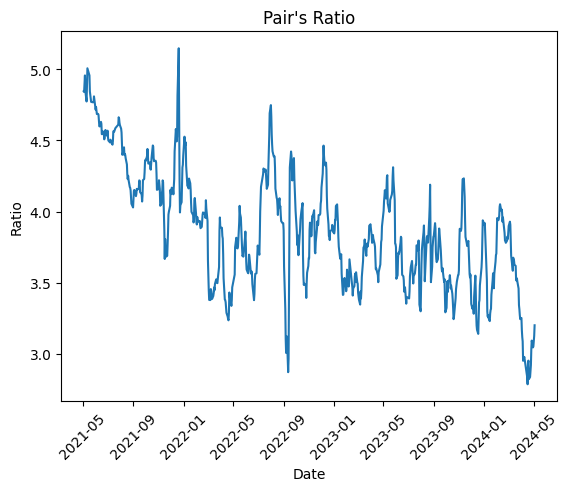

In [66]:
stock_a = ''
stock_b = ''
plt.plot(merged_data[stock_a]/merged_data[stock_b])
plt.xticks(rotation=45)
plt.title("Pair's Ratio")
plt.xlabel('Date')
plt.ylabel('Ratio')

As one can see above, this pair's ratio is not stationary although it is not alike a random walk which is desirable. At least it seems to show a mean reversive behavior as one can follow short/long position depending on the ratio's value.